# Story 3

### Do stricter gun laws reduce firearm gun deaths?

In [20]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from scipy.stats import pearsonr


## Datasources

We can use the below NCHS API endpoint to see cause of death rates per state *per quarter* in the US. This will be a good starting point as we look to visualize per state

- [NCHS Leading Cause of Deathe API Endpoint](https://dev.socrata.com/foundry/data.cdc.gov/bi63-dtpu)

In [21]:
# Grabbing data from API endpoint
response = requests.get("https://data.cdc.gov/resource/489q-934x.json").json()

In [22]:
# Write response to pandas dataframe
df = pd.json_normalize(response)
df.head()

,year_and_quarter,time_period,cause_of_death,rate_type,unit,rate_overall,rate_sex_female,rate_sex_male,rate_alaska,rate_alabama,...,rate_age_1_4,rate_age_5_14,rate_age_15_24,rate_age_25_34,rate_age_35_44,rate_age_45_54,rate_age_55_64,rate_65_74,rate_age_75_84,rate_age_85_plus
0,2022 Q1,12 months ending with quarter,All causes,Age-adjusted,"Deaths per 100,000",873.2,729.4,1038,944.5,1109.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022 Q1,12 months ending with quarter,Alzheimer disease,Age-adjusted,"Deaths per 100,000",30.6,35,23.8,28.5,45.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022 Q1,12 months ending with quarter,COVID-19,Age-adjusted,"Deaths per 100,000",95,75.2,119.1,121.3,133.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022 Q1,12 months ending with quarter,Cancer,Age-adjusted,"Deaths per 100,000",145.9,127.4,170.9,156,159.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022 Q1,12 months ending with quarter,Chronic liver disease and cirrhosis,Age-adjusted,"Deaths per 100,000",14.4,10.3,18.9,25.5,16.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling

In [23]:
# Pulling out only firearm deaths that are age-adjusted
df = df.loc[(df.cause_of_death == "Firearm-related injury") & (df.rate_type == "Age-adjusted") & (df.time_period=="3-month period")]

In [24]:
# Select only needed columns and transpose our data
state_cols = ['year_and_quarter', 'rate_alaska', 'rate_alabama', 'rate_arkansas', 'rate_arizona',
              'rate_california', 'rate_colorado', 'rate_connecticut',
              'rate_district_of_columbia', 'rate_delaware', 'rate_florida',
              'rate_georgia', 'rate_hawaii', 'rate_iowa', 'rate_idaho',
              'rate_illinois', 'rate_indiana', 'rate_kansas', 'rate_kentucky',
              'rate_louisiana', 'rate_massachusetts', 'rate_maryland', 'rate_maine',
              'rate_michigan', 'rate_minnesota', 'rate_missouri', 'rate_mississippi',
              'rate_montana', 'rate_north_carolina', 'rate_north_dakota',
              'rate_nebraska', 'rate_new_hampshire', 'rate_new_jersey',
              'rate_new_mexico', 'rate_nevada', 'rate_new_york', 'rate_ohio',
              'rate_oklahoma', 'rate_oregon', 'rate_pennsylvania',
              'rate_rhode_island', 'rate_south_carolina', 'rate_south_dakota',
              'rate_tennessee', 'rate_texas', 'rate_utah', 'rate_virginia',
              'rate_vermont', 'rate_washington', 'rate_wisconsin',
              'rate_west_virginia', 'rate_wyoming', 'rate_overall']
df = df[state_cols].transpose()

# Set the first row (year_and_quarter) as column headers and remove it from the data
df.columns = df.iloc[0]
df = df.drop(df.index[0])

# Clean up state names and set index
df['state'] = [s.replace("_", " ").replace("rate", "").title().strip() for s in df.index]
df = df.set_index('state')

# Convert column data to float, skipping over missing data (NaN)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the cleaned DataFrame
df.head()

year_and_quarter,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
state,,,,,,,,,
Alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
Alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
Arkansas,19.1,25.0,23.4,20.0,22.7,23.3,21.9,19.6,NaN
Arizona,18.6,22.6,20.7,18.6,18.0,18.3,18.9,18.8,NaN
California,8.3,8.9,9.4,7.9,8.1,7.7,8.4,7.4,NaN


## Data Visualization
Let's first plot the rate of firearm related homo

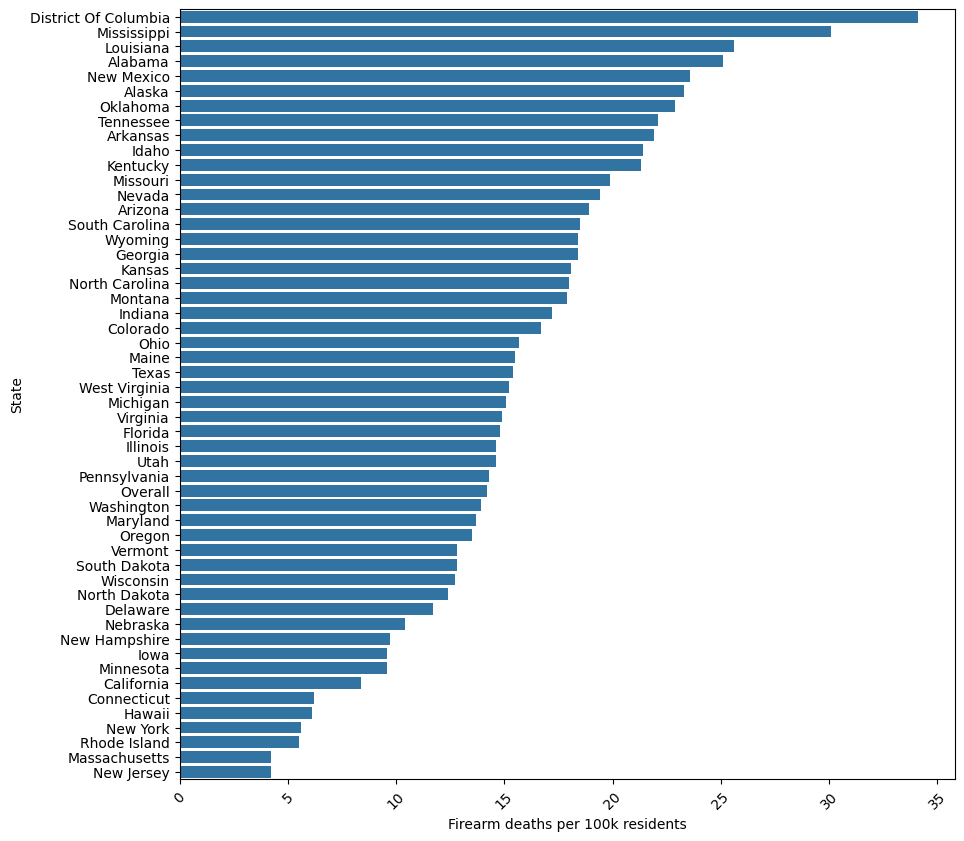

In [25]:
df_sorted = df.sort_values("2023 Q3", ascending=False)
order = df.groupby("state").sum().sort_values(['2023 Q3'], ascending=False).index

# Plot a sorted bar chart of deaths per 100k
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df, x="2023 Q3", y="state", order=order, orient="h")
ax.set_xlabel("Firearm deaths per 100k residents")
ax.set_ylabel("State")
plt.xticks(rotation=45)

plt.show()

- District of Columbia stands out as having the highest firearm death rate.

- Mississippi and Louisiana follow closely behind with high rates.

- New Jersey and Massachusetts have much lower rates of firearm-related deaths.

This pattern suggests a potential correlation between gun law strictness and firearm death rates, which can be further explored by merging the firearm mortality data with gun law ranking data (using your Likert scale approach). This will allow you to analyze the impact of gun control laws on the overall safety of residents in different states.

In [26]:
#  firearm mortality
df_firearm_mortality = pd.read_csv('https://raw.githubusercontent.com/waheeb123/Datasets/refs/heads/main/data-table.csv')

# Check the structure of the data
df_firearm_mortality.head()


,YEAR,STATE,RATE,DEATHS,URL
0,2022,AL,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm
1,2022,AK,22.4,164,/nchs/pressroom/states/alaska/ak.htm
2,2022,AZ,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm
3,2022,AR,21.9,666,/nchs/pressroom/states/arkansas/ar.htm
4,2022,CA,8.6,"3,484",/nchs/pressroom/states/california/ca.htm


In [27]:
# Load the gun law scorecard data
df_gun_law = pd.read_csv('https://raw.githubusercontent.com/waheeb123/Datasets/refs/heads/main/gifford-gun-law-scorecard.csv')

# Map the grades to a 5-point Likert scale
grade_to_likert = {
    'A': 5, 'A-': 5,
    'B+': 4, 'B': 4,
    'C+': 3, 'C': 3, 'C-': 3,
    'D+': 2, 'D': 2, 'D-': 2,
    'F': 1
}

# Apply the mapping to create a Likert scale column
df_gun_law['Likert_Scale'] = df_gun_law['grade'].map(grade_to_likert)

# Preview the DataFrame
df_gun_law.head()


,state,grade,Likert_Scale
0,Alabama,F,1
1,Alaska,F,1
2,Arizona,F,1
3,Arkansas,F,1
4,California,A,5


I have Created 5-Point Likert Scale for Gun Control Laws
We will assign each state to a Likert bin based on the gun law rankings from the gifford-gun-law-scorecard.csv file:

A / A-: Likert scale = 5 (Strictest laws)

B / B+: Likert scale = 4

C / C+: Likert scale = 3

D / D-: Likert scale = 2

F: Likert scale = 1 (Most lax laws)

2. Merge Gun Law Likert Scale Data with Firearm Mortality Data

In [28]:
# Dictionary to convert state abbreviations to full state names
us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Map state abbreviations to full state names
df_firearm_mortality['state_full'] = df_firearm_mortality['STATE'].map(us_state_abbrev)

# Merge using 'state_full' and 'state' in df_gun_law
df_combined = pd.merge(df_firearm_mortality, df_gun_law, left_on='state_full', right_on='state', how='inner')

# Drop the 'URL' and 'state_full' columns
df_combined = df_combined.drop(columns=['URL', 'state'])
# Preview the combined DataFrame
df_combined.head()



,YEAR,STATE,RATE,DEATHS,state_full,grade,Likert_Scale
0,2022,AL,25.5,"1,278",Alabama,F,1
1,2022,AK,22.4,164,Alaska,F,1
2,2022,AZ,20.1,"1,535",Arizona,F,1
3,2022,AR,21.9,666,Arkansas,F,1
4,2022,CA,8.6,"3,484",California,A,5


3. Visualize the Relationship Using Heat Maps

Pearson correlation coefficient: -0.6734769579354203
P-value: 2.3420899777237406e-67


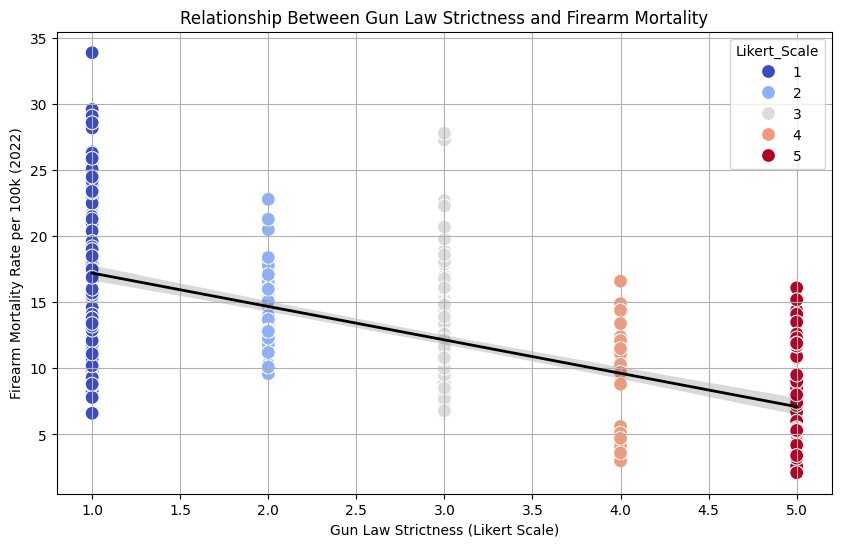

In [29]:
# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(df_combined['Likert_Scale'], df_combined['RATE'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Create the scatterplot with the regression line
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(data=df_combined, x='Likert_Scale', y='RATE', hue='Likert_Scale', palette='coolwarm', s=100)

# Regression line showing the correlation
sns.regplot(data=df_combined, x='Likert_Scale', y='RATE', scatter=False, color='black', line_kws={"linewidth": 2})

plt.title('Relationship Between Gun Law Strictness and Firearm Mortality')
plt.xlabel('Gun Law Strictness (Likert Scale)')
plt.ylabel('Firearm Mortality Rate per 100k (2022)')
plt.grid(True)

plt.show()


Pearson correlation coefficient: -0.673. This indicates a strong negative correlation between gun law strictness (Likert scale) and firearm mortality rate. In other words, as the strictness of gun laws increases, firearm mortality rates tend to decrease.
P-value: 2.34e-67: This extremely low p-value means that the correlation is statistically significant. There is very strong evidence to suggest that this relationship is not due to random chance.

In [30]:
import folium
import requests

# Load a GeoJSON file for state boundaries
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
geojson_data = requests.get(url).json()

# Create a folium map
us_map = folium.Map(location=[37.8, -96], zoom_start=4)

# Choropleth for Gun Law Strictness (Likert scale)
folium.Choropleth(
    geo_data=geojson_data,
    name='Gun Law Strictness (Likert Scale)',
    data=df_combined,
    columns=['state_full', 'Likert_Scale'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Gun Law Strictness (Likert Scale)'
).add_to(us_map)

# Add tooltips with state names
folium.GeoJson(
    geojson_data,
    name='State Names',
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['state_full:'],
        localize=True,
        sticky=False,
        labels=True,
        style="background-color: white; color: black; font-size: 14px; font-weight: bold;"
    )
).add_to(us_map)

# Add Layer Control
folium.LayerControl().add_to(us_map)

# Save the map to an HTML file
us_map.save('us_gun_law_map_interactive.html')

# Display the map in Google Colab
from google.colab import files
files.download('us_gun_law_map_interactive.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Added folium.Marker with popups to show both the state name and Likert scale value.

In [31]:
state_coordinates = {
    'Alabama': (32.806671, -86.791130),
    'Alaska': (61.370716, -152.404524),
    'Arizona': (33.729759, -111.431221),
    'Arkansas': (34.969704, -92.373123),
    'California': (36.116203, -119.681564),
    'Colorado': (39.059811, -105.311104),
    'Connecticut': (41.597782, -72.755371),
    'Delaware': (39.318523, -75.507141),
    'Florida': (27.766279, -81.686783),
    'Georgia': (33.040619, -83.643074),
    'Hawaii': (21.094318, -157.498337),
    'Idaho': (44.240459, -114.478828),
    'Illinois': (40.349457, -88.986137),
    'Indiana': (39.849426, -86.258278),
    'Iowa': (42.011539, -93.210526),
    'Kansas': (39.063946, -98.326),
    'Kentucky': (37.668140, -84.670067),
    'Louisiana': (31.169546, -91.867805),
    'Maine': (44.693947, -69.381927),
    'Maryland': (39.063946, -76.802101),
    'Massachusetts': (42.230171, -71.530106),
    'Michigan': (43.326618, -84.536095),
    'Minnesota': (45.694454, -93.900192),
    'Mississippi': (32.741646, -89.678696),
    'Missouri': (37.536503, -92.173516),
    'Montana': (46.921925, -110.454353),
    'Nebraska': (41.492537, -99.901810),
    'Nevada': (38.313515, -117.055374),
    'New Hampshire': (43.452492, -71.563896),
    'New Jersey': (40.298904, -74.521011),
    'New Mexico': (34.840515, -106.248482),
    'New York': (42.165726, -74.948051),
    'North Carolina': (35.630066, -79.806419),
    'North Dakota': (47.528912, -99.784012),
    'Ohio': (40.388783, -82.764915),
    'Oklahoma': (35.565342, -96.928917),
    'Oregon': (44.572021, -122.070938),
    'Pennsylvania': (40.590752, -77.209755),
    'Rhode Island': (41.680893, -71.511780),
    'South Carolina': (33.856892, -80.945007),
    'South Dakota': (44.299782, -99.438828),
    'Tennessee': (35.747845, -86.692345),
    'Texas': (31.054487, -97.563461),
    'Utah': (40.150032, -111.862434),
    'Vermont': (44.045876, -72.710686),
    'Virginia': (37.769337, -78.169968),
    'Washington': (47.400902, -121.490494),
    'West Virginia': (38.491226, -80.954987),
    'Wisconsin': (43.784440, -88.787868),
    'Wyoming': (42.755966, -107.302490)
}


In [32]:
df_combined['latitude'] = df_combined['state_full'].map(lambda x: state_coordinates[x][0] if x in state_coordinates else None)
df_combined['longitude'] = df_combined['state_full'].map(lambda x: state_coordinates[x][1] if x in state_coordinates else None)

# Now you can use the updated df_combined DataFrame for your map


In [33]:
import folium
import requests

# Load the GeoJSON file for state boundaries
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
geojson_data = requests.get(url).json()

# Create a folium map
us_map = folium.Map(location=[37.8, -96], zoom_start=4)

# Choropleth for Gun Law Strictness (Likert scale)
folium.Choropleth(
    geo_data=geojson_data,
    name='Gun Law Strictness (Likert Scale)',
    data=df_combined,
    columns=['state_full', 'Likert_Scale'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Gun Law Strictness (Likert Scale)'
).add_to(us_map)

# Add tooltips with state names and Likert Scale values
folium.GeoJson(
    geojson_data,
    name='State Names and Likert Scale',
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['State:'],
        localize=True,
        sticky=False,
        labels=True,
        style="background-color: white; color: black; font-size: 14px; font-weight: bold;"
    )
).add_to(us_map)

# Iterate over the data to display Likert Scale in the tooltip
for idx, row in df_combined.iterrows():
    state_name = row['state_full']
    likert_value = row['Likert_Scale']

    # Add circle markers for each state with tooltips
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f'{state_name}: Likert Scale {likert_value}',
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(us_map)

# Add Layer Control
folium.LayerControl().add_to(us_map)

# Save the map to an HTML file
us_map.save('us_gun_law_map_interactive_with_values.html')

# Display the map in Google Colab
from google.colab import files
files.download('us_gun_law_map_interactive_with_values.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Conclusion

The findings of this Story 3 indicate a significant inverse correlation between gun law strictness and firearm mortality rates. The Pearson correlation coefficient of approximately -0.67 suggests that states with stricter gun laws tend to experience lower rates of firearm-related deaths. Furthermore, the data visualizations, including heat maps and scatterplots, vividly illustrate the disparities across states, revealing how legislative measures may play a role in mitigating firearm violence. While this study highlights a promising relationship between stricter gun laws and reduced firearm deaths, it is essential to acknowledge the multifaceted nature of gun violence. Socioeconomic factors, mental health resources, and community programs also contribute to this complex issue. Therefore, while stricter gun laws can be an effective strategy in reducing firearm mortality, comprehensive approaches that address underlying causes of gun violence will be crucial in enhancing public safety.

In [34]:
import folium
import requests

# Load a GeoJSON file for state boundaries
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
geojson_data = requests.get(url).json()

# Create a folium map centered on the US
us_map = folium.Map(location=[37.8, -96], zoom_start=4)

# Define color palette: softer colors for visual comfort
color_palette = 'BuPu'  # Blue-purple shades are visually soothing

# Choropleth for Gun Law Strictness (Likert scale)
folium.Choropleth(
    geo_data=geojson_data,
    name='Gun Law Strictness (Likert Scale)',
    data=df_combined,
    columns=['state_full', 'Likert_Scale'],
    key_on='feature.properties.name',
    fill_color=color_palette,  # Softer color palette
    fill_opacity=0.7,
    line_opacity=0.3,  # Increased for clearer boundaries
    legend_name='Gun Law Strictness (Likert Scale)',
    nan_fill_color='lightgray',  # Softer handling of NaN values
    nan_fill_opacity=0.5
).add_to(us_map)

# Add tooltips with state names
folium.GeoJson(
    geojson_data,
    name='State Names',
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['State:'],
        localize=True,
        sticky=False,
        labels=True,
        style="background-color: white; color: black; font-size: 12px; font-weight: bold;"
    )
).add_to(us_map)

# Add Layer Control for toggling visibility of map layers
folium.LayerControl(collapsed=False).add_to(us_map)

# Display the map
us_map


In [40]:
!pip install folium
!pip install branca
!pip install streamlit-folium



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


In [41]:
import folium
import requests
from streamlit_folium import folium_static  # Correct import for Colab

# Load a GeoJSON file for state boundaries
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
geojson_data = requests.get(url).json()

# Create a folium map centered on the US
us_map = folium.Map(location=[37.8, -96], zoom_start=4)

# Define color palette: softer colors for visual comfort
color_palette = 'PuBuGn'  # Pastel shades of purples, blues, and greens

# Choropleth for Gun Law Strictness (Likert scale)
folium.Choropleth(
    geo_data=geojson_data,
    name='Gun Law Strictness (Likert Scale)',
    data=df_combined,  # Ensure your df_combined dataframe is loaded in Colab
    columns=['state_full', 'Likert_Scale'],
    key_on='feature.properties.name',
    fill_color=color_palette,  # Softer color palette
    fill_opacity=0.7,
    line_opacity=0.3,  # Slightly stronger line for better contrast
    legend_name='Gun Law Strictness (Likert Scale)',
    nan_fill_color='lightgray',  # Handle NaN values gracefully
    nan_fill_opacity=0.5
).add_to(us_map)

# Add tooltips with state names
folium.GeoJson(
    geojson_data,
    name='State Names',
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['State:'],
        localize=True,
        sticky=False,
        labels=True,
        style="background-color: white; color: black; font-size: 12px; font-weight: bold;"
    )
).add_to(us_map)

# Add Layer Control for toggling visibility of map layers
folium.LayerControl(collapsed=False).add_to(us_map)

# Display the map in Google Colab using folium_static
folium_static(us_map)


2024-10-10 22:17:17.798 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
<ipython-input-41-fbf06230140d>:48: DeprecationWarning: 
folium_static is deprecated and will be removed in a future release, or
simply replaced with with st_folium which always passes
returned_objects=[] to the component.
Please try using st_folium instead, and
post an issue at https://github.com/randyzwitch/streamlit-folium/issues
if you experience issues with st_folium.

  folium_static(us_map)
2024-10-10 22:17:18.390 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-10 22:17:18.579 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-10-10 22:17:18.590 Thread 'MainThread': missing ScriptRunContext! This warning c

DeltaGenerator()